# results from static simulation using reframed and SteadyCom

set-up for simulations:

In [12]:
from reframed import Community, Environment
from reframed import load_cbmodel, FBA, plot_flux_envelope

#load all models
CAL2 = load_cbmodel("../GEMs/CAL2.xml", flavor="bigg")
SAL9 = load_cbmodel("../GEMs/SAL9.xml", flavor="bigg")
MAM2 = load_cbmodel("../GEMs/MAM2.xml", flavor="bigg")
MRA = load_cbmodel("../GEMs/MRA.xml", flavor="bigg")

In [13]:
# impose constraints on SAL9 reactions so that the model cannot go crazy with the loop

SAL9.reactions.R_HPPHD.set_flux_bounds(0, float("inf"))
SAL9.reactions.R_DHPPSA.set_flux_bounds(0, float("inf"))
SAL9.reactions.R_DLDH.set_flux_bounds(float("-inf"), 0)
SAL9.reactions.R_HPLSA.set_flux_bounds(0, float("inf"))

# likewise on the MRA model
MRA.reactions.R_HPPHD.set_flux_bounds(0, float("inf"))
MRA.reactions.R_DHPPSA.set_flux_bounds(0, float("inf"))
MRA.reactions.R_DLDH.set_flux_bounds(float("-inf"), 0)
MRA.reactions.R_HPLSA.set_flux_bounds(0, float("inf"))

In [3]:
# in order to equal the playing field between BL21 and K12 derived models:

# adjust the biomass reaction
SAL9.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_atp_c"] = -75.55223
SAL9.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_h_c"] = 75.377230
SAL9.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_adp_c"] = 75.377230
SAL9.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_pi_c"] = 75.373230
SAL9.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry["M_h2o_c"] = -70.028756

# adjust the ATP maintanance requrenment
SAL9.reactions.R_ATPM.lb = 6.86

In [14]:
# build community object
community = Community('RA_community', [CAL2, SAL9, MAM2])
merged_community = community.merge_models()

# get medium
medium = Environment.from_model(CAL2).apply(merged_community, exclusive=True, inplace=False)

## Maximal theoretical RA production

### with standard FBA

In [61]:
# community

FBA_com_sol = FBA(merged_community, constraints=medium, objective='R_EX_rosma_e')
print(FBA_com_sol)

Objective: 2.465929203539822
Status: Optimal



In [62]:
# code to convert the community solution into something plottable in the escher diagram

from collections import defaultdict

# Create a defaultdict to accumulate values for keys without the suffix
result_dict = defaultdict(int)

# Iterate through the original dictionary
for key, value in FBA_com_sol.values.items():
    # Remove the 5-character suffix from the key
    new_key = key[:-5]
    
    # Add the value to the corresponding key (taking the absolute value)
    result_dict[new_key] += abs(value)

# Convert the defaultdict back to a regular dictionary if needed
FBA_com_sol_translated = dict(result_dict)

In [63]:
from escher import Builder

com_flux_map = Builder(map_json="reaction_map.json")
com_flux_map.reaction_data = FBA_com_sol_translated
com_flux_map

Builder(reaction_data={'community_g': 0.0, 'R_CYTDK2': 0.0, 'R_XPPT': 0.0, 'R_HXPRT': 0.0, 'R_NDPK5': 0.0, 'R_…

- in the TYRTA reaction: in CAL2 it is moving towards tyrosine production, but in SAL9 it is going the other way 

In [65]:
# monoculture

FBA_mono_sol = FBA(MRA, constraints=medium, objective='R_EX_rosma_e')
print(FBA_mono_sol)

Objective: 2.63959843837146
Status: Optimal



In [66]:
from escher import Builder

mono_flux_map = Builder(map_json="reaction_map.json")
mono_flux_map.reaction_data = FBA_mono_sol.values
mono_flux_map

Builder(reaction_data={'R_CYTDK2': 0.0, 'R_XPPT': 0.0, 'R_HXPRT': 0.0, 'R_NDPK5': 0.0, 'R_SHK3Dr': 5.279196876…

- the theoretical max RA production rate is higher for the monoculture than for the community

### with SteadyCom

In [67]:
# community

import updated_steadycom

sc_com_som = updated_steadycom.SteadyCom(community, constraints=medium, objective="R_EX_rosma_e")
print("RA production rate: ", sc_com_som.values["R_EX_rosma_e"])

RA production rate:  0.001301137657264917


In [68]:
# code to convert the community solution into something plottable in the escher diagram

from collections import defaultdict

# Create a defaultdict to accumulate values for keys without the suffix
result_dict = defaultdict(int)

# Iterate through the original dictionary
for key, value in sc_com_som.values.items():
    # Remove the 5-character suffix from the key
    new_key = key[:-5]
    
    # Add the value to the corresponding key (taking the absolute value)
    result_dict[new_key] += abs(value)

# Convert the defaultdict back to a regular dictionary if needed
sc_com_som_translated = dict(result_dict)

from escher import Builder

com_flux_map = Builder(map_json="reaction_map.json")
com_flux_map.reaction_data = sc_com_som_translated
com_flux_map

Builder(reaction_data={'x': 1.0, 'community_g': 0.9033203125, 'R_CYTDK2': 0.0, 'R_XPPT': 0.0, 'R_HXPRT': 0.0, …

In [69]:
# monoculture

import updated_steadycom

monoculture = Community('monoculture', [MRA])

sc_mono_som = updated_steadycom.SteadyCom(monoculture, constraints=medium, objective="R_EX_rosma_e")
print("RA production rate: ", sc_mono_som.values["R_EX_rosma_e"])

RA production rate:  0.0013122903878769188


In [70]:
from escher import Builder

mono_flux_map = Builder(map_json="reaction_map.json")
mono_flux_map.reaction_data = {key[:-4]:value for (key,value) in sc_mono_som.values.items()}
mono_flux_map

Builder(reaction_data={'x': 1.0, 'community_gr': 0.9033203125, 'R_CYTDK2': 0.0, 'R_XPPT': 0.0, 'R_HXPRT': 0.0,…

## Relative species abundance
using steadycom FVA

without modification of SAL9 ATP requrements:

  0%|          | 0/11 [00:00<?, ?it/s]

Text(0.5, 0, 'fraction of optimal solution')

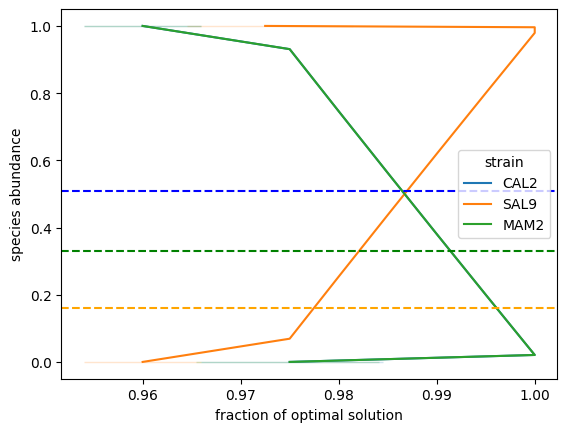

In [7]:
from reframed import SteadyComVA
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_list = []

#for i in tqdm(range(950, 1001, 1)):
for i in tqdm(range(950, 1005, 5)):
    frac = i/1000
    com_fva_solution = SteadyComVA(community, constraints=medium, obj_frac=frac)
    com_fva_solution["frac"] = frac
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list)
results_df.set_index("frac")

plot_df = results_df.explode(["CAL2", "SAL9", "MAM2"])
df_melt = plot_df.melt('frac', var_name='strain', value_name='species abundance')

sns.lineplot(data=df_melt, x="frac", y="species abundance", hue="strain",orient="y")

#stipled lines with exp. steady-state species abundance
plt.axhline(y=0.51, linestyle='--', color='blue')
plt.axhline(y=0.16, linestyle='--', color='orange')
plt.axhline(y=0.33, linestyle='--', color='green')

plt.xlabel("fraction of optimal solution")

with the updated ATP requrenments for SAL9

In [10]:
from reframed import SteadyComVA
com_fva_solution = SteadyComVA(community, constraints=medium, obj_frac=1)
print(com_fva_solution)

{'CAL2': [0.0, 1.0], 'SAL9': [0.0, 0.9967979230542133], 'MAM2': [0.0, 1.0]}


- the optimal solution kind of permits any constillation 
 - this is likely because it is not constrained enough -> adding constraints that force RA production will solve this.

## Relative species abundance for different levels of RA production

In [15]:
import updated_steadycom
from reframed import SteadyComVA
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

num_points = 11

sc_com_som = updated_steadycom.SteadyCom(community, constraints=medium, objective="R_EX_rosma_e")
max_RA = sc_com_som.values["R_EX_rosma_e"]

RA_vals = np.linspace(max_RA, 0.001041, num=num_points) #hard-coded to go to 80%

all_constraints = medium
results_list = []

# go "down" from max RA level to zero production in 10 steps and monitor the solution
for i in tqdm(range(num_points)):
    RA_level = RA_vals[i]
    
    #update the RA reaction constraint
    all_constraints["R_EX_rosma_e"] = (RA_level, float("inf"))
    
    com_fva_solution = SteadyComVA(community, constraints=all_constraints, obj_frac=1)

    com_fva_solution["RA_prod_rate"] = RA_level
    #com_fva_solution["RA_percentage"] = 100 - i*(num_points-1)
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list)
results_df["RA_percentage"] = np.linspace(100, 80, num_points)

  0%|          | 0/11 [00:00<?, ?it/s]

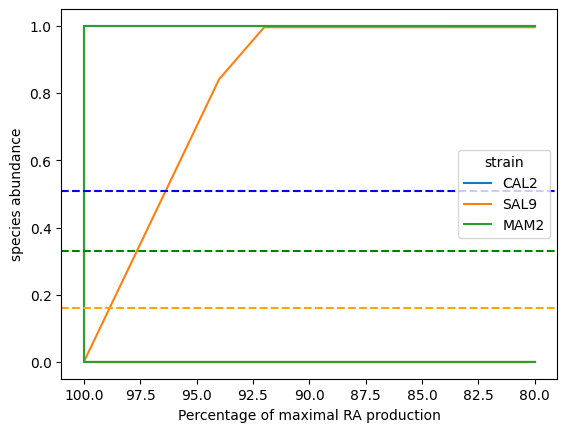

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = results_df.explode(["CAL2", "SAL9", "MAM2"])
df_melt = plot_df.drop(columns=["RA_prod_rate"]).melt('RA_percentage', var_name='strain', value_name='species abundance')

#sns.lineplot(data=df_melt, x="RA_prod_rate", y="species abundance", hue="strain",orient="y")
sns.lineplot(data=df_melt, x="RA_percentage", y="species abundance", hue="strain",orient="y")

#stipled lines with exp. steady-state species abundance
plt.axhline(y=0.51, linestyle='--', color='blue')
plt.axhline(y=0.16, linestyle='--', color='orange')
plt.axhline(y=0.33, linestyle='--', color='green')

plt.xlabel("Percentage of maximal RA production")

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

- solution space is still very wide... How does the solution look without the adjusted SAL9 ATP reqs?

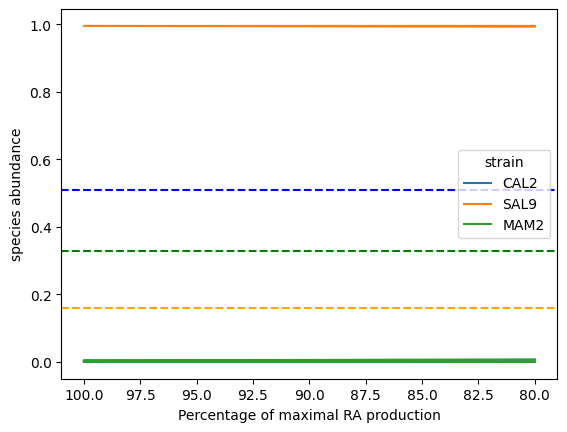

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = results_df.explode(["CAL2", "SAL9", "MAM2"])
df_melt = plot_df.drop(columns=["RA_prod_rate"]).melt('RA_percentage', var_name='strain', value_name='species abundance')

#sns.lineplot(data=df_melt, x="RA_prod_rate", y="species abundance", hue="strain",orient="y")
sns.lineplot(data=df_melt, x="RA_percentage", y="species abundance", hue="strain",orient="y")

#stipled lines with exp. steady-state species abundance
plt.axhline(y=0.51, linestyle='--', color='blue')
plt.axhline(y=0.16, linestyle='--', color='orange')
plt.axhline(y=0.33, linestyle='--', color='green')

plt.xlabel("Percentage of maximal RA production")

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

- then its a lot of SAL9, and very little CAL2/MAM2 all the time, completeally misses the mark (this is notably for obj_frac = 1)

# Monoculture production

look at the theoretical maximal product formulation in the monoculture

In [1]:
from reframed import Community, Environment
from reframed import load_cbmodel, FBA, plot_flux_envelope
from config import ROOT_DIR

mra_path = ROOT_DIR / "community_modelling" / "GEMs" / "MRA.xml"
MRA = load_cbmodel(str(mra_path), flavor="bigg")

In [5]:
medium = Environment.from_model(MRA).apply(MRA, exclusive=True, inplace=False)
medium["R_EX_phe__L_e"] = (-10, float("inf")) #adding phenylalanine to the media since pheA is knocked out

In [6]:
FBA(MRA, constraints=medium)

Objective: 0.9037654323222015
Status: Optimal

<AxesSubplot: xlabel='E. coli biomass objective function (iML1515) - core - with 75.37 GAM estimate', ylabel='Rosmarinic acid exchange'>

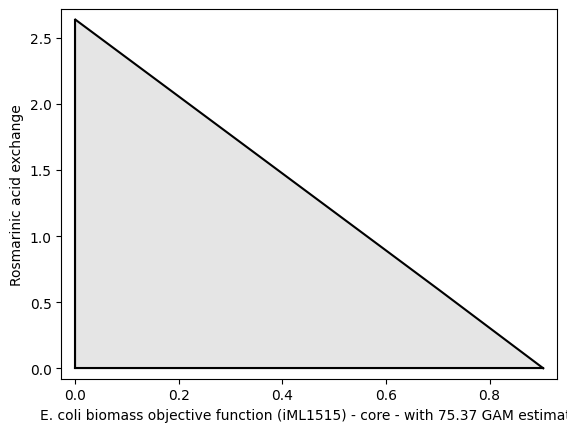

In [7]:
plot_flux_envelope(MRA, MRA.biomass_reaction, 'R_EX_rosma_e', constraints=medium)

In [10]:
theoretical_RA_opt = FBA(MRA, constraints=medium, objective='R_EX_rosma_e')
print(theoretical_RA_opt)

Objective: 2.639598438371436
Status: Optimal



In [12]:
from GEM_eval import saa_loop

saa_loop(theoretical_RA_opt, community=False)

False

# Testing biomass reactions

In [1]:
from reframed import Community, Environment
from reframed import load_cbmodel, FBA, plot_flux_envelope

#load all models
k12 = load_cbmodel("../GEMs/iML1515.xml", flavor="bigg")
bl21 = load_cbmodel("../GEMs/iHK1487.xml", flavor="bigg")

In [13]:
k12_bm = k12.reactions.R_BIOMASS_Ec_iML1515_core_75p37M.stoichiometry
bl21_bm = bl21.reactions.R_BIOMASS_Ec_iHK1487_core.stoichiometry

In [19]:
difference = set(k12_bm.keys()) - set(bl21_bm.keys())
print(len(difference))

0


In [45]:
import pandas as pd
import numpy as np

rows = []

for metabolite in k12_bm.keys():
    if not np.isclose(k12_bm[metabolite], bl21_bm[metabolite], 0.000001):
        rows.append([metabolite, k12_bm[metabolite], bl21_bm[metabolite]])

df = pd.DataFrame(rows, columns=['metabolite', 'k12 biomass', 'bl21 biomass'])
abs_diff = abs(df["k12 biomass"] - df["bl21 biomass"])
df["diff"] = abs_diff

df.sort_values("diff", ascending=False)[0:5]

,metabolite,k12 biomass,bl21 biomass,diff
5,M_atp_c,-75.552230,-70.294831,5.257399
51,M_h_c,75.377230,70.120000,5.257230
50,M_adp_c,75.377230,70.120000,5.257230
52,M_pi_c,75.373230,70.116052,5.257178
23,M_h2o_c,-70.028756,-64.946357,5.082399


- the largest differences in biomass are the above 5 species - for everything else the differences are a scale of less than 10^-4
- therefore adapt the biomass equation of SAL9 to adhere to the k12 values for ATP, H+, ADP, Pi, and H2O

In [55]:
print("ATPM for k12:", k12.reactions.R_ATPM.lb)
print("ATPM for bl21:", bl21.reactions.R_ATPM.lb)

ATPM for k12: 6.86
ATPM for bl21: 5.17


- there is also a higher ATP maintanance value for k12 -> adjust the bl21 value accordingly